# 查看FashionMNIST原始数据格式

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model


In [3]:
import json
token = {"username":"huangdongsheng123","key":"bc7074d3e7a23aa7233f350712ff381d"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cat /content/kaggle.json

{"username": "huangdongsheng123", "key": "bc7074d3e7a23aa7233f350712ff381d"}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [6]:
!kaggle competitions download -c cifar-10

 96% 689M/715M [00:03<00:00, 116MB/s] 
100% 715M/715M [00:03<00:00, 203MB/s]


In [7]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [8]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 32.5 MB/s eta 0:00:00


In [9]:
!ls competitions/cifar-10/train|wc -l

50000


# 加载数据并处理为tensor

In [10]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# 加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"
# img_dir = r"D:\cifar-10\train\train"
# labels_file = r"D:\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")



完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [11]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

# 把数据集划分为训练集45000和验证集5000，并给DataLoader

In [12]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)




# 搭建模型

In [13]:
#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


# 搭建InceptionNet模型

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义Inception模块
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, pool_proj):
        super(InceptionBlock, self).__init__()

        # 1x1卷积分支
        self.branch1 = nn.Conv2d(in_channels, out1x1, kernel_size=1) #64

        # 3x3卷积分支
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),#96
            nn.BatchNorm2d(red3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out3x3),
            nn.ReLU(inplace=True)
        ) #128

        # 5x5卷积分支
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1), #16
            nn.BatchNorm2d(red5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True)
        ) #32

        # 最大池化分支
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1), #32
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        # 在通道维度上拼接四个分支的输出
        return torch.cat([branch1, branch2, branch3, branch4], 1)

# 定义InceptionNet模型
class InceptionNetV1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # 初始卷积层
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Inception模块
        self.inception1 = InceptionBlock(64, 64, 96, 128, 16, 32, 32)  # 输出通道: 64+128+32+32=256

        # 池化层
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第二个Inception模块
        self.inception2 = InceptionBlock(256, 128, 128, 192, 32, 96, 64)  # 输出通道: 128+192+96+64=480

        # 池化层
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全连接层
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(480 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # 卷积块
        x = self.conv_block1(x)

        # Inception块
        # 第一个Inception块: 输入[batch_size, 64, 16, 16] -> 输出[batch_size, 256, 16, 16]
        x = self.inception1(x)
        # print(f'inception1: {x.shape}')
        # 池化层: 输入[batch_size, 256, 16, 16] -> 输出[batch_size, 256, 8, 8]
        x = self.maxpool1(x)

        # 第二个Inception块: 输入[batch_size, 256, 8, 8] -> 输出[batch_size, 480, 8, 8]
        x = self.inception2(x)
        # print(f'inception2: {x.shape}')
        # 池化层: 输入[batch_size, 480, 8, 8] -> 输出[batch_size, 480, 4, 4]
        x = self.maxpool2(x)

        # 展平: 将[batch_size, 480, 4, 4]转换为[batch_size, 480*4*4]
        x = torch.flatten(x, 1)

        # 分类器
        x = self.classifier(x)

        return x

In [15]:
# 实例化模型
model = InceptionNetV1()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [16]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 4467162
模型总参数量: 4467162

各层参数量明细:
conv_block1.0.weight: 1728 参数
conv_block1.0.bias: 64 参数
conv_block1.1.weight: 64 参数
conv_block1.1.bias: 64 参数
inception1.branch1.weight: 4096 参数
inception1.branch1.bias: 64 参数
inception1.branch2.0.weight: 6144 参数
inception1.branch2.0.bias: 96 参数
inception1.branch2.1.weight: 96 参数
inception1.branch2.1.bias: 96 参数
inception1.branch2.3.weight: 110592 参数
inception1.branch2.3.bias: 128 参数
inception1.branch2.4.weight: 128 参数
inception1.branch2.4.bias: 128 参数
inception1.branch3.0.weight: 1024 参数
inception1.branch3.0.bias: 16 参数
inception1.branch3.1.weight: 16 参数
inception1.branch3.1.bias: 16 参数
inception1.branch3.3.weight: 12800 参数
inception1.branch3.3.bias: 32 参数
inception1.branch3.4.weight: 32 参数
inception1.branch3.4.bias: 32 参数
inception1.branch4.1.weight: 2048 参数
inception1.branch4.1.bias: 32 参数
inception1.branch4.2.weight: 32 参数
inception1.branch4.2.bias: 32 参数
inception2.branch1.weight: 32768 参数
inception2.branch1.bias: 128 参数
inception2.bra

In [17]:
128*3*3*256

294912

In [18]:
model.state_dict()

OrderedDict([('conv_block1.0.weight',
              tensor([[[[ 0.1034, -0.1266,  0.1657],
                        [-0.1007, -0.1182,  0.0889],
                        [ 0.0813, -0.0527,  0.0989]],
              
                       [[ 0.1555, -0.0725, -0.1649],
                        [-0.1685,  0.1803, -0.0828],
                        [-0.1506,  0.0507, -0.0497]],
              
                       [[-0.1014, -0.0810,  0.0054],
                        [-0.1607,  0.0386,  0.0752],
                        [ 0.0766, -0.1105, -0.0430]]],
              
              
                      [[[-0.1540,  0.0795, -0.1587],
                        [-0.0366, -0.0648, -0.0280],
                        [ 0.1388,  0.1070, -0.1277]],
              
                       [[-0.1893, -0.0985,  0.0546],
                        [-0.0092,  0.0774, -0.0603],
                        [-0.0975, -0.1085, -0.0771]],
              
                       [[-0.1339, -0.0973,  0.0019],
                  

# 设置交叉熵损失函数，SGD优化器

In [20]:
model = InceptionNetV1()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)



损失函数: CrossEntropyLoss()


In [22]:
model = InceptionNetV1()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0
训练开始，共35200步


  0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 82.7800
早停: 在21500 步


In [24]:
history['train'][-100:-1]

[{'loss': 0.2662862539291382, 'acc': 92.1875, 'step': 21401},
 {'loss': 0.1912062019109726, 'acc': 90.625, 'step': 21402},
 {'loss': 0.18813328444957733, 'acc': 95.3125, 'step': 21403},
 {'loss': 0.39072105288505554, 'acc': 89.0625, 'step': 21404},
 {'loss': 0.12122281640768051, 'acc': 96.875, 'step': 21405},
 {'loss': 0.32008329033851624, 'acc': 90.625, 'step': 21406},
 {'loss': 0.3096142113208771, 'acc': 87.5, 'step': 21407},
 {'loss': 0.1464584320783615, 'acc': 95.3125, 'step': 21408},
 {'loss': 0.15910568833351135, 'acc': 93.75, 'step': 21409},
 {'loss': 0.20158587396144867, 'acc': 95.3125, 'step': 21410},
 {'loss': 0.3123586177825928, 'acc': 84.375, 'step': 21411},
 {'loss': 0.2747577726840973, 'acc': 93.75, 'step': 21412},
 {'loss': 0.19256709516048431, 'acc': 95.3125, 'step': 21413},
 {'loss': 0.2916901707649231, 'acc': 87.5, 'step': 21414},
 {'loss': 0.0823371559381485, 'acc': 96.875, 'step': 21415},
 {'loss': 0.33690884709358215, 'acc': 89.0625, 'step': 21416},
 {'loss': 0.269

In [25]:
history['val'][-1000:-1]

[{'loss': 2.3035231472015383, 'acc': 12.32, 'step': 0},
 {'loss': 1.2796020893096924, 'acc': 54.48, 'step': 500},
 {'loss': 1.0714868333816527, 'acc': 61.96, 'step': 1000},
 {'loss': 0.9646613166809082, 'acc': 65.46, 'step': 1500},
 {'loss': 0.8842304597854614, 'acc': 68.1, 'step': 2000},
 {'loss': 0.8625862502098084, 'acc': 69.42, 'step': 2500},
 {'loss': 0.782295795917511, 'acc': 72.94, 'step': 3000},
 {'loss': 0.7545930823326111, 'acc': 73.2, 'step': 3500},
 {'loss': 0.7960588702201843, 'acc': 71.86, 'step': 4000},
 {'loss': 0.7092360749244689, 'acc': 74.28, 'step': 4500},
 {'loss': 0.7015374528884888, 'acc': 74.44, 'step': 5000},
 {'loss': 0.6870678322076798, 'acc': 76.1, 'step': 5500},
 {'loss': 0.6546356806278228, 'acc': 76.52, 'step': 6000},
 {'loss': 0.6398681168079376, 'acc': 77.5, 'step': 6500},
 {'loss': 0.6610642571210861, 'acc': 77.08, 'step': 7000},
 {'loss': 0.6295975717663765, 'acc': 77.82, 'step': 7500},
 {'loss': 0.6414522057771683, 'acc': 77.4, 'step': 8000},
 {'loss

# 绘制损失曲线和准确率曲线

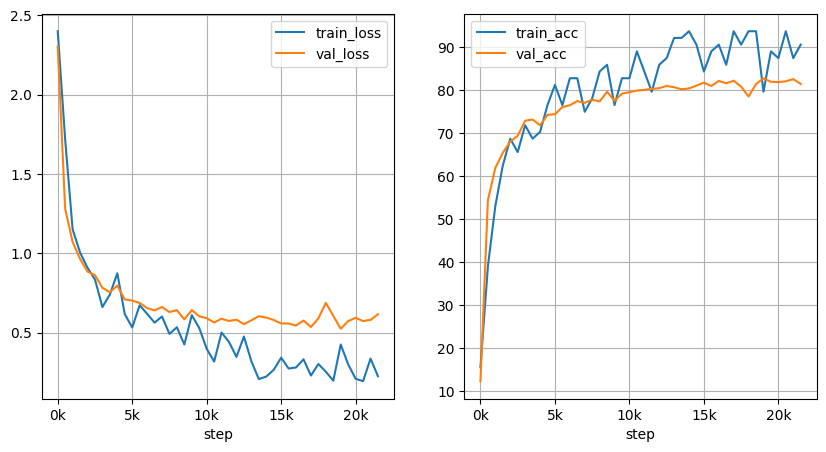

In [26]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [28]:
# 导入所需库
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        初始化测试数据集

        参数:
            img_dir: 测试图片目录
            transform: 图像预处理变换
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 提取图像ID（文件名去掉扩展名）
        img_id = int(os.path.splitext(self.img_files[idx])[0])

        return image, img_id

# 定义预测函数
def predict_test_set(model, img_dir, labels_file, device, batch_size=64):
    """
    预测测试集并生成提交文件

    参数:
        model: 训练好的模型
        img_dir: 测试图片目录
        labels_file: 提交模板文件路径
        device: 计算设备
        batch_size: 批处理大小
    """
    # 图像预处理变换（与训练集相同）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
    ])

    # 创建测试数据集和数据加载器
    test_dataset = CIFAR10TestDataset(img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 设置模型为评估模式
    model.eval()

    # 读取提交模板
    submission_df = pd.read_csv(labels_file)
    predictions = {}

    # 使用tqdm显示进度条
    print("正在预测测试集...")
    with torch.no_grad():
        for images, img_ids in tqdm.tqdm(test_loader, desc="预测进度"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #取最大的索引，作为预测结果

            # 记录每个图像的预测结果
            for i, img_id in enumerate(img_ids):
                predictions[img_id.item()] = predicted[i].item() #因为一个批次有多个图像，所以需要predicted[i]

    # 定义类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 将数值标签转换为类别名称
    labeled_predictions = {img_id: class_names[pred] for img_id, pred in predictions.items()}

    # 直接创建DataFrame
    submission_df = pd.DataFrame({
        'id': list(labeled_predictions.keys()),
        'label': list(labeled_predictions.values())
    })

    # 按id列排序
    submission_df = submission_df.sort_values(by='id')

    # 检查id列是否有重复值
    has_duplicates = submission_df['id'].duplicated().any()
    print(f"id列是否有重复值: {has_duplicates}")

    # 保存预测结果
    output_file = 'cifar10_submission.csv'
    submission_df.to_csv(output_file, index=False)
    print(f"预测完成，结果已保存至 {output_file}")

# 执行测试集预测
# 执行测试集预测
img_dir = r"competitions/cifar-10/train"
labels_file = r"./sampleSubmission.csv"
predict_test_set(model, img_dir, labels_file, device, batch_size=128)


正在预测测试集...


预测进度: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

id列是否有重复值: False
预测完成，结果已保存至 cifar10_submission.csv
